In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.ticker as mticker
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow import keras 

from pickle import dump

In [2]:
experiment = 'control'

missingdataindex = np.load(f'Data_Step2/{experiment}/missingdataindex.npy')
maskTraining = np.load(f'Data_Step2/{experiment}/maskTraining.npy')
maskVal = np.load(f'Data_Step2/{experiment}/maskVal.npy')
maskTest = np.load(f'Data_Step2/{experiment}/maskTest.npy')

num_clusters = 6

total_features = np.load(f'Data_Step2/{experiment}/total_features.npy')
total_labels = np.load(f'Data_Step2/{experiment}/total_labels_{num_clusters}_clusters.npy')

train_features = np.load(f'Data_Step2/{experiment}/train_features.npy')
train_labels = np.load(f'Data_Step2/{experiment}/train_labels_{num_clusters}_clusters.npy')

val_features = np.load(f'Data_Step2/{experiment}/val_features.npy')
val_labels = np.load(f'Data_Step2/{experiment}/val_labels_{num_clusters}_clusters.npy')

test_features = np.load(f'Data_Step2/{experiment}/test_features.npy')
test_labels = np.load(f'Data_Step2/{experiment}/test_labels_{num_clusters}_clusters.npy')

In [3]:
scaler = StandardScaler()
scaler.fit(train_features)
print(scaler.mean_, scaler.scale_)

dump(scaler, open(f'Data_Step2/{experiment}/scaler.pkl', 'wb'))

[-2.85953411e-11  3.68473248e+03 -2.93517822e-01 -1.78395655e-05
  7.85527389e-05  2.14230237e-03  4.95123948e-07  6.49555247e-07
  3.01111445e+08 -1.45646523e+07] [1.86685043e-10 1.61048766e+03 7.99068436e-01 1.03240757e-04
 6.63678833e-01 4.30530589e-02 1.86624197e-05 2.45397653e-06
 1.35950753e+09 9.36660921e+08]


In [4]:
X_total_scaled = scaler.transform(total_features)
Y_total = tf.keras.utils.to_categorical(total_labels)

X_train_scaled = scaler.transform(train_features)
Y_train = tf.keras.utils.to_categorical(train_labels)

X_val_scaled = scaler.transform(val_features)
Y_val = tf.keras.utils.to_categorical(val_labels)

X_test_scaled = scaler.transform(test_features)
Y_test = tf.keras.utils.to_categorical(test_labels)

X_train_scaled.shape, Y_train.shape

((481049, 10), (481049, 6))

In [5]:
Y_total.shape[0], Y_total.shape

(834418, (834418, 6))

In [6]:
model_name = f'model_24x2_16x2_tanh_{num_clusters}_clusters'
ensemble_size = 50

prob_predictions = np.empty(shape=(ensemble_size, Y_total.shape[0], Y_total.shape[1]))
for i in range(ensemble_size):
    model = tf.keras.models.load_model(f'saved_models/{model_name}/model_{i}.h5')
    prob_predictions[i] = model(X_total_scaled).numpy()

prob_mean = prob_predictions.mean(axis = 0)

In [7]:
col_height = xr.open_dataset(f'Data_Step2/{experiment}/col_height.nc').rename({'yh':'lat', 'xh':'lon'})

# Ensure that longitude coords are from -180 to 180
col_height.coords['lon'] = (col_height.coords['lon'] + 180) % 360 - 180
col_height = col_height.sortby(col_height.lon)

In [8]:
mom6_labels = xr.open_dataset(f'Data_Step2/control/mom6_labels_{num_clusters}_clusters.nc')['Label']
# Ensure that longitude coords are from -180 to 180
mom6_labels.coords['lon'] = (mom6_labels.coords['lon'] + 180) % 360 - 180
mom6_labels = mom6_labels.sortby(mom6_labels.lon)

In [9]:
pred = np.nan * np.zeros((1080,1440))
pred[~missingdataindex] = prob_mean.argmax(axis=1)
pred = xr.DataArray(data=pred,
                    dims=['lat','lon'],
                    coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                    name='Model Pred')

correct_idx = np.where(np.argmax(prob_mean, axis=1) == np.argmax(Y_total, axis=1), 1, 0)
tf_vals = np.nan * np.zeros((1080,1440))
tf_vals[~missingdataindex] = correct_idx
tf_vals = xr.DataArray(data=tf_vals,
                       dims=['lat','lon'],
                       coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                       name='true-false')

entropy_vals = -np.sum(prob_mean * np.log2(prob_mean), axis=1)
entropy = np.nan * np.zeros((1080,1440))
entropy[~missingdataindex] = entropy_vals
entropy = xr.DataArray(data=entropy,
                       dims=['lat','lon'],
                       coords=dict(lat=col_height['lat'], lon=col_height['lon']),
                       name='Entropy')

In [10]:
pred.to_netcdf(f'Data_Step2/{experiment}/{model_name}_ensemble_mean_pred.nc')

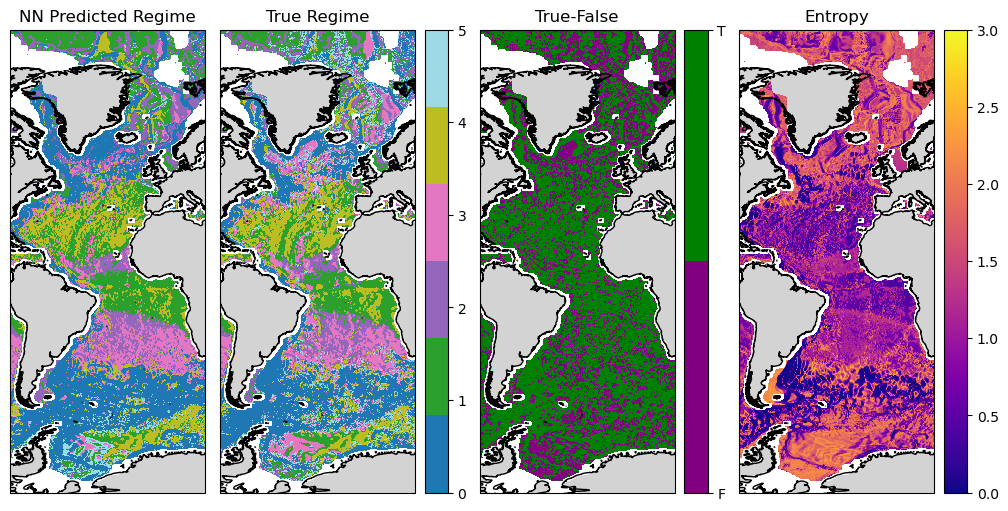

In [11]:
fig, axes = plt.subplots(1, 4, subplot_kw={'projection':ccrs.Miller()}, figsize=(10,5), constrained_layout=True)

pred.isel(lon=slice(400,800)).plot(ax=axes[0], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('tab20', num_clusters), add_colorbar=False)
mom6_labels.isel(lon=slice(400,800)).plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('tab20', num_clusters), cbar_kwargs={'label':''})
pcm = tf_vals.isel(lon=slice(400,800)).plot(ax=axes[2], transform=ccrs.PlateCarree(),
                                            cmap=ListedColormap(['purple', 'green']),
                                            add_colorbar=False)
tf_cbar = fig.colorbar(pcm, ax=axes[2], ticks=[0,1])
tf_cbar.ax.set_yticklabels(['F','T'])
entropy.isel(lon=slice(400,800)).plot(ax=axes[3], transform=ccrs.PlateCarree(), cmap='plasma',
                                      cbar_kwargs={'label':''}, vmin=0, vmax=3)

axes[0].set_title('NN Predicted Regime')
axes[0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0].coastlines(resolution='10m')

axes[1].set_title('True Regime')
axes[1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1].coastlines(resolution='10m')

axes[2].set_title('True-False')
axes[2].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[2].coastlines(resolution='10m')

axes[3].set_title('Entropy')
axes[3].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[3].coastlines(resolution='10m')

plt.savefig('figures/neurips/piControl_training_summary.png', transparent=False, dpi=600)

plt.show()

In [12]:
entropy.to_netcdf(f'Data_Step2/{experiment}/entropy.nc')

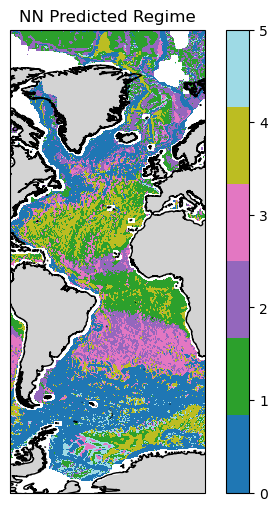

In [13]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.Miller()}, figsize=(5,5), constrained_layout=True)

pred.isel(lon=slice(400,800)).plot(ax=axes, transform=ccrs.PlateCarree(),
                                   cmap=plt.get_cmap('tab20', num_clusters), cbar_kwargs={'label':''})

axes.set_title('NN Predicted Regime')
axes.add_feature(cfeature.LAND, facecolor='lightgrey')
axes.coastlines(resolution='10m')

plt.show()

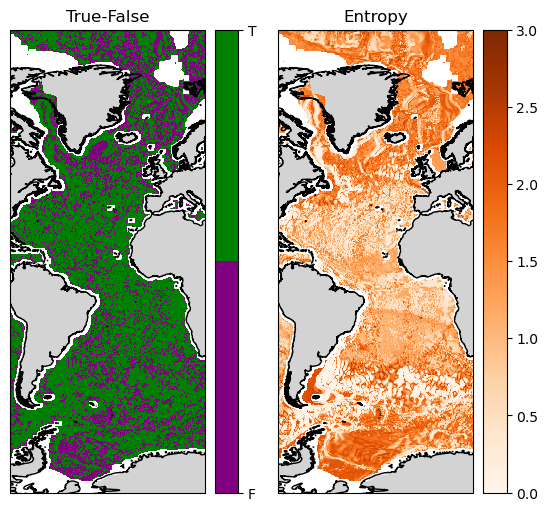

In [14]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection':ccrs.Miller()}, figsize=(5.5,5), constrained_layout=True)

pcm = tf_vals.isel(lon=slice(400,800)).plot(ax=axes[0], transform=ccrs.PlateCarree(),
                                            cmap=ListedColormap(['purple', 'green']),
                                            add_colorbar=False)
tf_cbar = fig.colorbar(pcm, ax=axes[0], ticks=[0,1])
tf_cbar.ax.set_yticklabels(['F','T'])
entropy.isel(lon=slice(400,800)).plot(ax=axes[1], transform=ccrs.PlateCarree(), cmap = plt.cm.Oranges,
                                      cbar_kwargs={'label':''}, vmin=0, vmax=3)

axes[0].set_title('True-False')
axes[0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0].coastlines(resolution='10m')

axes[1].set_title('Entropy')
axes[1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1].coastlines(resolution='10m')

plt.show()

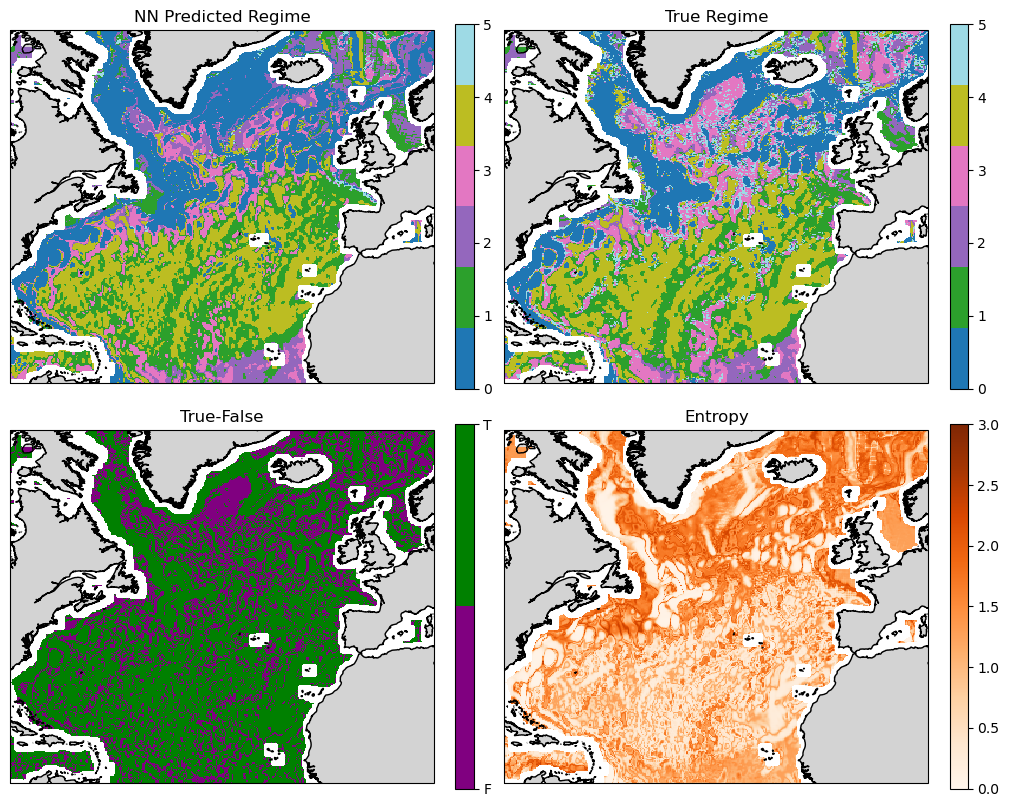

In [15]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection':ccrs.Miller()}, figsize=(10,8), constrained_layout=True)

pred.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[0,0], transform=ccrs.PlateCarree(),
                                                       cmap=plt.get_cmap('tab20', num_clusters), add_colorbar=True,
                                                       vmin=0, vmax=num_clusters-1, cbar_kwargs={'label':''})
mom6_labels.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[0,1], transform=ccrs.PlateCarree(),
                                                              cmap=plt.get_cmap('tab20', num_clusters), 
                                                              vmin=0, vmax=num_clusters-1, cbar_kwargs={'label':''})
pcm = tf_vals.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[1,0], transform=ccrs.PlateCarree(),
                                                                cmap=ListedColormap(['purple', 'green']),
                                                                add_colorbar=False)
tf_cbar = fig.colorbar(pcm, ax=axes[1,0], ticks=[0,1])
tf_cbar.ax.set_yticklabels(['F','T'])
entropy.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[1,1], transform=ccrs.PlateCarree(),
                                                          cmap = plt.cm.Oranges, cbar_kwargs={'label':''},
                                                          vmin=0, vmax=3)

axes[0,0].set_title('NN Predicted Regime')
axes[0,0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0,0].coastlines(resolution='10m')

axes[0,1].set_title('True Regime')
axes[0,1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0,1].coastlines(resolution='10m')

axes[1,0].set_title('True-False')
axes[1,0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1,0].coastlines(resolution='10m')

axes[1,1].set_title('Entropy')
axes[1,1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1,1].coastlines(resolution='10m')

plt.show()

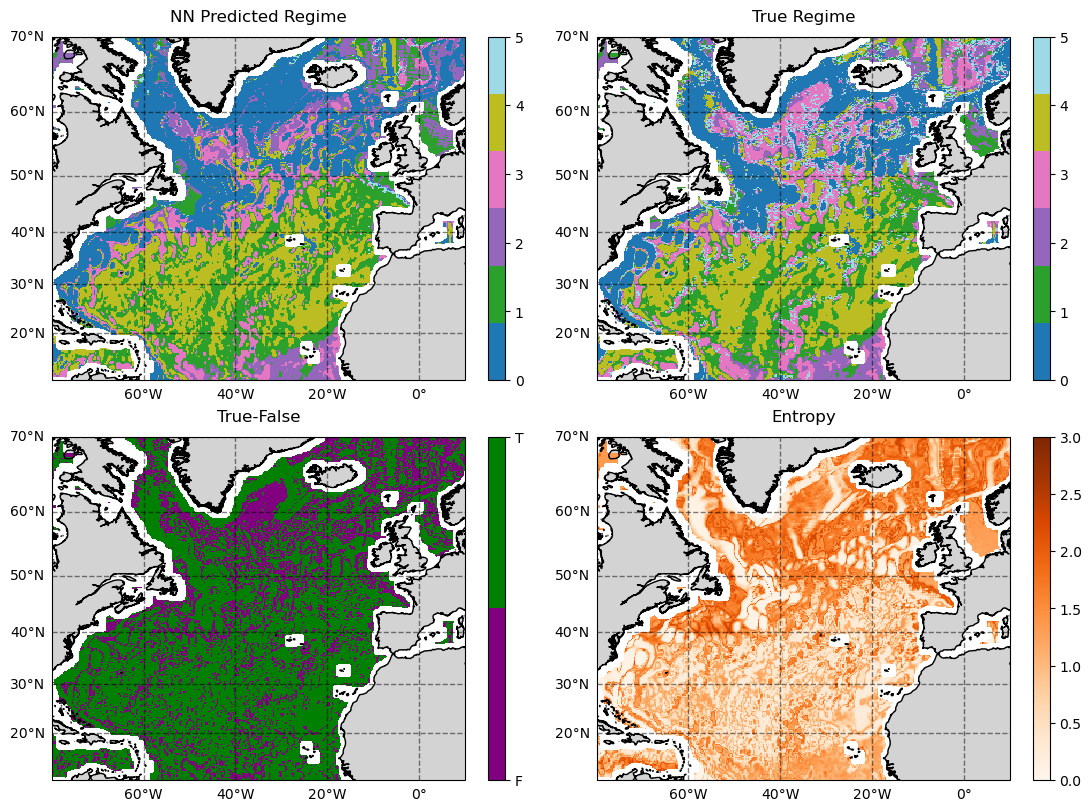

In [16]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection':ccrs.Miller()}, figsize=(11,8), constrained_layout=True)

pred.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[0,0], transform=ccrs.PlateCarree(),
                                                       cmap=plt.get_cmap('tab20', num_clusters), add_colorbar=True,
                                                       vmin=0, vmax=num_clusters-1, cbar_kwargs={'label':''})
mom6_labels.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[0,1], transform=ccrs.PlateCarree(),
                                                              cmap=plt.get_cmap('tab20', num_clusters),
                                                              vmin=0, vmax=num_clusters-1, cbar_kwargs={'label':''})
pcm = tf_vals.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[1,0], transform=ccrs.PlateCarree(),
                                                                cmap=ListedColormap(['purple', 'green']),
                                                                add_colorbar=False)
tf_cbar = fig.colorbar(pcm, ax=axes[1,0], ticks=[0,1])
tf_cbar.ax.set_yticklabels(['F','T'])
entropy.sel(lon=slice(-80,10)).sel(lat=slice(10,70)).plot(ax=axes[1,1], transform=ccrs.PlateCarree(),
                                                          cmap = plt.cm.Oranges, cbar_kwargs={'label':''},
                                                          vmin=0, vmax=3)

axes[0,0].set_title('NN Predicted Regime')
axes[0,0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0,0].coastlines(resolution='10m')

axes[0,1].set_title('True Regime')
axes[0,1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0,1].coastlines(resolution='10m')

axes[1,0].set_title('True-False')
axes[1,0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1,0].coastlines(resolution='10m')

axes[1,1].set_title('Entropy')
axes[1,1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1,1].coastlines(resolution='10m')

for i in range(2):
    for j in range(2):
        gl = axes[i,j].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False

plt.show()

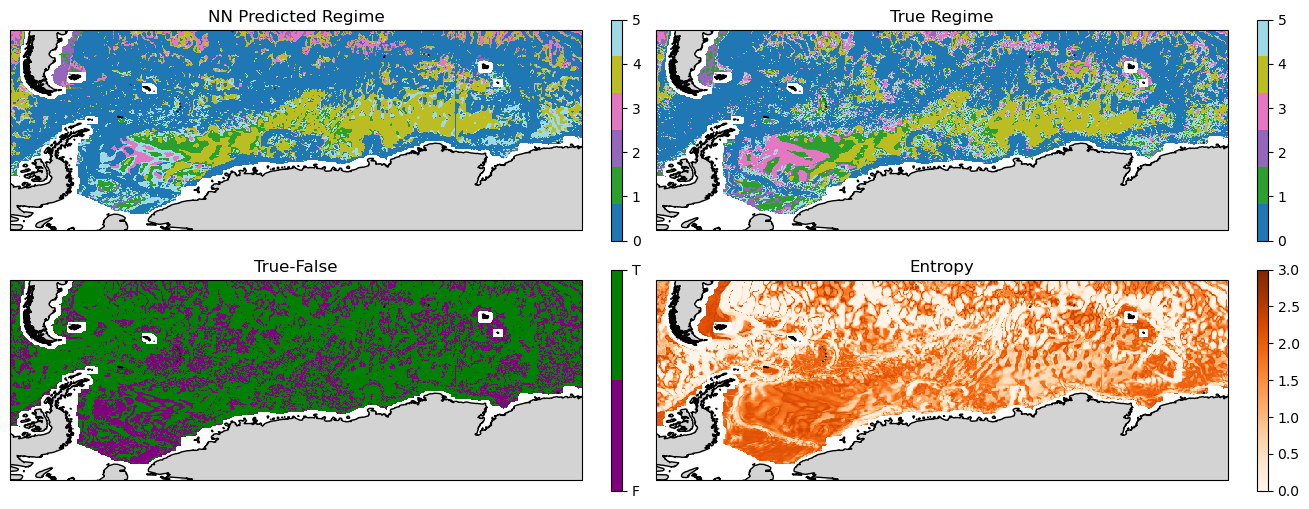

In [17]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection':ccrs.Miller()}, figsize=(13,5), constrained_layout=True)

pred.sel(lon=slice(-80,100)).sel(lat=slice(-80,-40)).plot(ax=axes[0,0], transform=ccrs.PlateCarree(),
                                                          cmap=plt.get_cmap('tab20', num_clusters), add_colorbar=True,
                                                          vmin=0, vmax=num_clusters-1, cbar_kwargs={'label':''})
mom6_labels.sel(lon=slice(-80,100)).sel(lat=slice(-80,-40)).plot(ax=axes[0,1], transform=ccrs.PlateCarree(),
                                                                 cmap=plt.get_cmap('tab20', num_clusters),
                                                                 vmin=0, vmax=num_clusters-1, cbar_kwargs={'label':''})
pcm = tf_vals.sel(lon=slice(-80,100)).sel(lat=slice(-80,-40)).plot(ax=axes[1,0], transform=ccrs.PlateCarree(),
                                                                cmap=ListedColormap(['purple', 'green']),
                                                                add_colorbar=False)
tf_cbar = fig.colorbar(pcm, ax=axes[1,0], ticks=[0,1])
tf_cbar.ax.set_yticklabels(['F','T'])
entropy.sel(lon=slice(-80,100)).sel(lat=slice(-80,-40)).plot(ax=axes[1,1], transform=ccrs.PlateCarree(),
                                                             cmap = plt.cm.Oranges, cbar_kwargs={'label':''},
                                                             vmin=0, vmax=3)

axes[0,0].set_title('NN Predicted Regime')
axes[0,0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0,0].coastlines(resolution='10m')

axes[0,1].set_title('True Regime')
axes[0,1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0,1].coastlines(resolution='10m')

axes[1,0].set_title('True-False')
axes[1,0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1,0].coastlines(resolution='10m')

axes[1,1].set_title('Entropy')
axes[1,1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1,1].coastlines(resolution='10m')

plt.show()

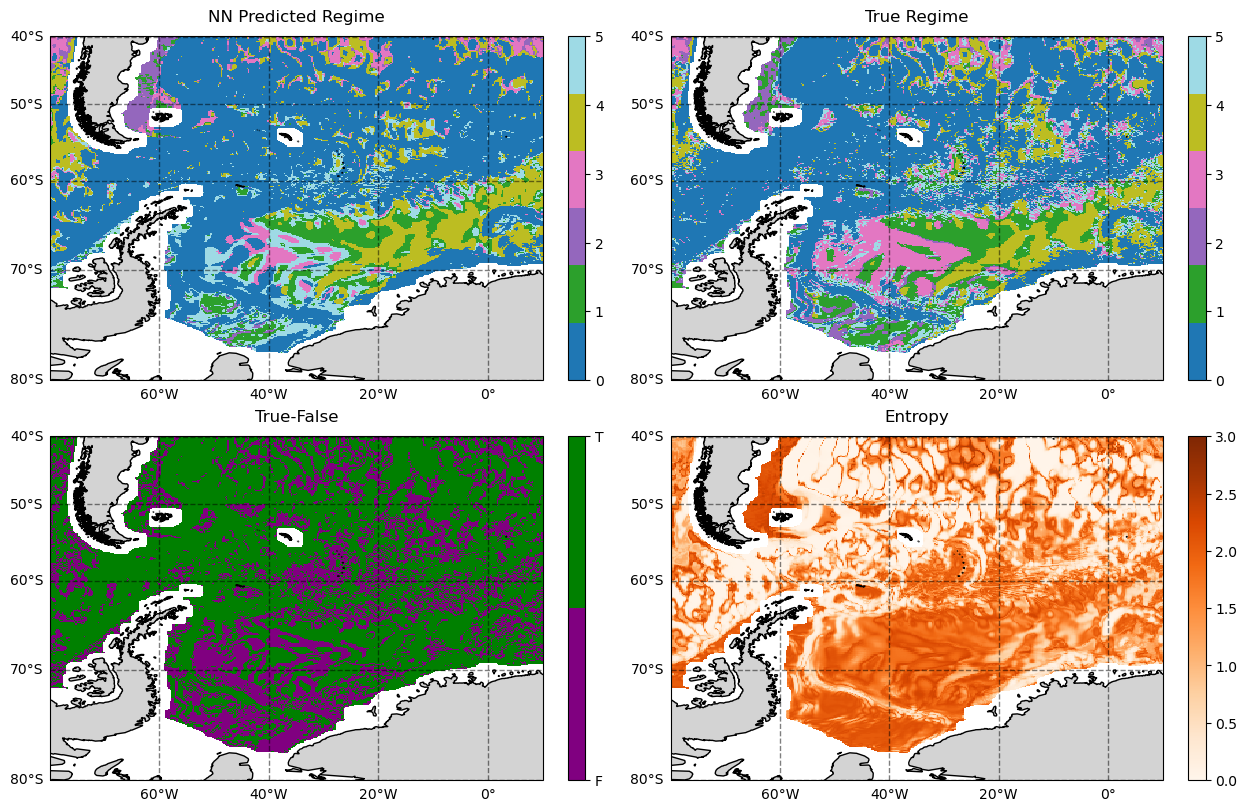

In [18]:
fig, axes = plt.subplots(2, 2, subplot_kw={'projection':ccrs.Miller()}, figsize=(12.5,8), constrained_layout=True)

pred.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40)).plot(ax=axes[0,0], transform=ccrs.PlateCarree(),
                                                          cmap=plt.get_cmap('tab20', num_clusters), add_colorbar=True,
                                                          vmin=0, vmax=num_clusters-1, cbar_kwargs={'label':''})
mom6_labels.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40)).plot(ax=axes[0,1], transform=ccrs.PlateCarree(),
                                                                 cmap=plt.get_cmap('tab20', num_clusters),
                                                                 vmin=0, vmax=num_clusters-1, cbar_kwargs={'label':''})
pcm = tf_vals.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40)).plot(ax=axes[1,0], transform=ccrs.PlateCarree(),
                                                                cmap=ListedColormap(['purple', 'green']),
                                                                add_colorbar=False)
tf_cbar = fig.colorbar(pcm, ax=axes[1,0], ticks=[0,1])
tf_cbar.ax.set_yticklabels(['F','T'])
entropy.sel(lon=slice(-80,10)).sel(lat=slice(-80,-40)).plot(ax=axes[1,1], transform=ccrs.PlateCarree(),
                                                             cmap = plt.cm.Oranges, cbar_kwargs={'label':''},
                                                             vmin=0, vmax=3)

axes[0,0].set_title('NN Predicted Regime')
axes[0,0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0,0].coastlines(resolution='10m')

axes[0,1].set_title('True Regime')
axes[0,1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[0,1].coastlines(resolution='10m')

axes[1,0].set_title('True-False')
axes[1,0].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1,0].coastlines(resolution='10m')

axes[1,1].set_title('Entropy')
axes[1,1].add_feature(cfeature.LAND, facecolor='lightgrey')
axes[1,1].coastlines(resolution='10m')

for i in range(2):
    for j in range(2):
        gl = axes[i,j].gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False

plt.show()

Avg entropy of correctly labeled cells: 0.9691492894821894
Avg entropy of incorrectly labeled cells: 1.5612673879613468


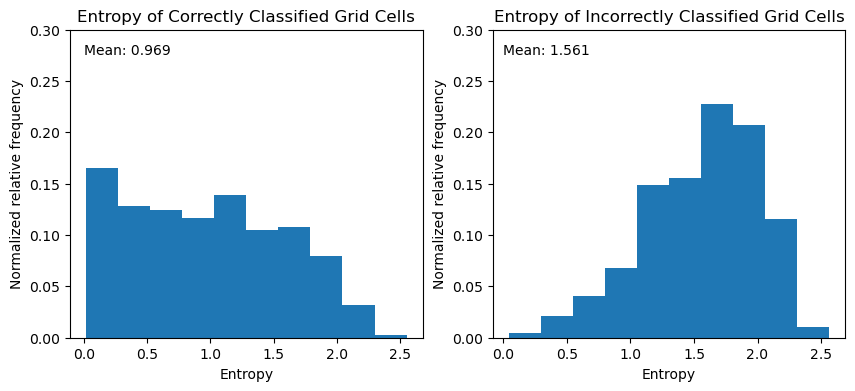

In [22]:
entropy_correct = xr.where(tf_vals.data.flatten()[maskTest.flatten()] == 1, entropy.data.flatten()[maskTest.flatten()], np.nan)
entropy_correct = entropy_correct[~np.isnan(entropy_correct)]

entropy_incorrect = xr.where(tf_vals.data.flatten()[maskTest.flatten()] == 0, entropy.data.flatten()[maskTest.flatten()], np.nan)
entropy_incorrect = entropy_incorrect[~np.isnan(entropy_incorrect)]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(entropy_correct, weights=(1/len(entropy_correct))*np.ones(len(entropy_correct)))
axes[0].set_title('Entropy of Correctly Classified Grid Cells')
axes[0].set_xlabel('Entropy')
axes[0].set_ylabel('Normalized relative frequency')
axes[0].text(0, 0.28, f'Mean: {np.round(np.mean(entropy_correct), 3)}', horizontalalignment='left', verticalalignment='center')
axes[0].set_ylim([0, 0.3])

axes[1].hist(entropy_incorrect, weights=(1/len(entropy_incorrect))*np.ones(len(entropy_incorrect)))
axes[1].set_title('Entropy of Incorrectly Classified Grid Cells')
axes[1].set_xlabel('Entropy')
axes[1].set_ylabel('Normalized relative frequency')
axes[1].text(0, 0.28, f'Mean: {np.round(np.mean(entropy_incorrect), 3)}', horizontalalignment='left', verticalalignment='center')
axes[1].set_ylim([0, 0.3])

print(f'Avg entropy of correctly labeled cells: {np.mean(entropy_correct)}')
print(f'Avg entropy of incorrectly labeled cells: {np.mean(entropy_incorrect)}')

plt.savefig('figures/neurips/entropy_distributions.png', transparent=False, dpi=600)

plt.show()

Avg entropy of correctly labeled cells: 0.9691492894821894
Avg entropy of incorrectly labeled cells: 1.5612673879613468


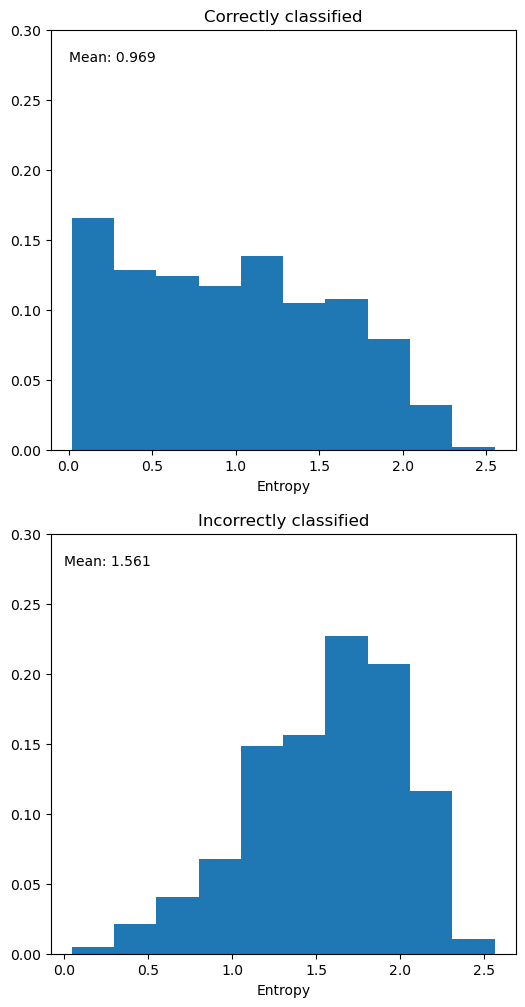

In [20]:
entropy_correct = xr.where(tf_vals.data.flatten()[maskTest.flatten()] == 1, entropy.data.flatten()[maskTest.flatten()], np.nan)
entropy_correct = entropy_correct[~np.isnan(entropy_correct)]

entropy_incorrect = xr.where(tf_vals.data.flatten()[maskTest.flatten()] == 0, entropy.data.flatten()[maskTest.flatten()], np.nan)
entropy_incorrect = entropy_incorrect[~np.isnan(entropy_incorrect)]

fig, axes = plt.subplots(2, 1, figsize=(6, 12))

axes[0].hist(entropy_correct, weights=(1/len(entropy_correct))*np.ones(len(entropy_correct)))
axes[0].set_title('Correctly classified')
axes[0].set_xlabel('Entropy')
axes[0].text(0, 0.28, f'Mean: {np.round(np.mean(entropy_correct), 3)}', horizontalalignment='left', verticalalignment='center')
axes[0].set_ylim([0, 0.3])

axes[1].hist(entropy_incorrect, weights=(1/len(entropy_incorrect))*np.ones(len(entropy_incorrect)))
axes[1].set_title('Incorrectly classified')
axes[1].set_xlabel('Entropy')
axes[1].text(0, 0.28, f'Mean: {np.round(np.mean(entropy_incorrect), 3)}', horizontalalignment='left', verticalalignment='center')
axes[1].set_ylim([0, 0.3])

print(f'Avg entropy of correctly labeled cells: {np.mean(entropy_correct)}')
print(f'Avg entropy of incorrectly labeled cells: {np.mean(entropy_incorrect)}')

plt.show()

Avg entropy of correctly labeled cells: 1.0214962161404215
Avg entropy of incorrectly labeled cells: 1.538908335999088


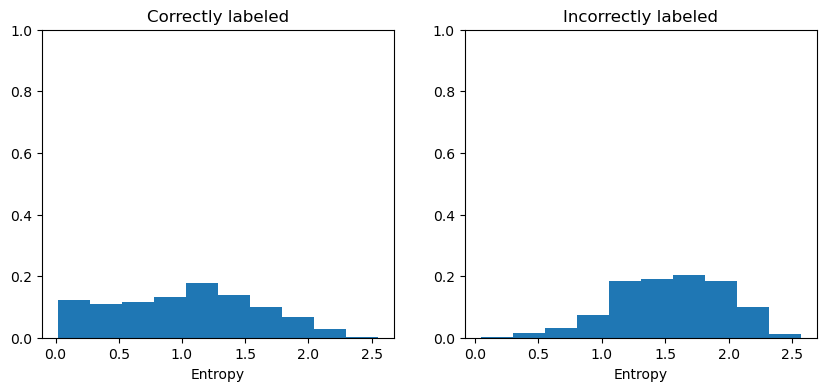

In [21]:
entropy_correct = xr.where(tf_vals == 1, entropy, np.nan).data.flatten()
entropy_correct = entropy_correct[~np.isnan(entropy_correct)]

entropy_incorrect = xr.where(tf_vals == 0, entropy, np.nan).data.flatten()
entropy_incorrect = entropy_incorrect[~np.isnan(entropy_incorrect)]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(entropy_correct, weights=(1/len(entropy_correct))*np.ones(len(entropy_correct)))
axes[0].set_title('Correctly labeled')
axes[0].set_xlabel('Entropy')
axes[0].set_ylim([0, 1])

axes[1].hist(entropy_incorrect, weights=(1/len(entropy_incorrect))*np.ones(len(entropy_incorrect)))
axes[1].set_title('Incorrectly labeled')
axes[1].set_xlabel('Entropy')
axes[1].set_ylim([0, 1])

print(f'Avg entropy of correctly labeled cells: {np.mean(entropy_correct)}')
print(f'Avg entropy of incorrectly labeled cells: {np.mean(entropy_incorrect)}')

plt.show()

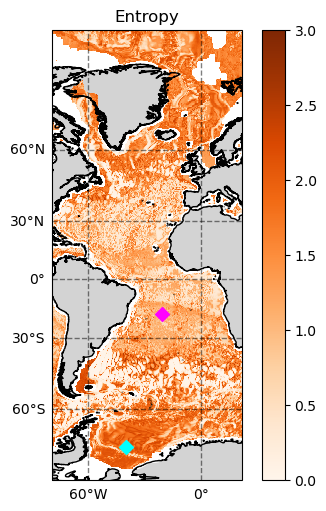

In [22]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.Miller()}, figsize=(5,5), constrained_layout=True)
entropy.isel(lon=slice(400,800)).plot(ax=axes, transform=ccrs.PlateCarree(), cmap = plt.cm.Oranges,
                                      vmin=0, vmax=3, cbar_kwargs={'label':''})
axes.set_title('Entropy')
axes.add_feature(cfeature.LAND, facecolor='lightgrey')
axes.coastlines(resolution='10m')

#axes.scatter(-40, 23.75, transform=ccrs.PlateCarree(), marker='D', c='black', s=50)
#axes.scatter(-45, 57, transform=ccrs.PlateCarree(), marker='D', c='blue', s=50)
axes.scatter(-21, -18, transform=ccrs.PlateCarree(), marker='D', c='magenta', s=50)
#axes.scatter(-35, 61, transform=ccrs.PlateCarree(), marker='D', c='lightgreen', s=50)
axes.scatter(-40, -72, transform=ccrs.PlateCarree(), marker='D', c='cyan', s=50)

gl = axes.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60,0])

plt.show()

In [23]:
prob_predictions_swapped = np.swapaxes(prob_predictions, 0, 1)
prob_predictions_full = np.nan * np.zeros((1080,1440,ensemble_size,num_clusters))
prob_predictions_full[~missingdataindex] = prob_predictions_swapped

prob_predictions_full = xr.DataArray(data=prob_predictions_full,
                                     dims=['lat','lon','member', 'label'],
                                     coords=dict(lat=col_height['lat'], lon=col_height['lon'],
                                                 member=list(range(ensemble_size)), label=list(range(num_clusters))),
                                     name='Predictions')

In [24]:
def plot_predicted_probabilities(lon, lat):
    label_ensemble_preds = []
    correct_label = mom6_labels.sel(lon=lon, method='nearest').sel(lat=lat, method='nearest').data

    for i in range(num_clusters):
        label_ensemble_preds.append(prob_predictions_full.sel(lon=lon, method='nearest').sel(lat=lat, method='nearest').data[:,i])

    fig, ax = plt.subplots()
    bplot = ax.boxplot(label_ensemble_preds, patch_artist=True, boxprops={'fill': None})

    for i in range(num_clusters):
        if i == correct_label:
            bplot['boxes'][i].set_edgecolor('green')
            bplot['medians'][i].set_color('green')
        else:
            bplot['boxes'][i].set_edgecolor('purple')
            bplot['medians'][i].set_color('purple')

    ax.set_xticklabels(list(range(num_clusters)))
    ax.set_xlabel('Regime')
    ax.set_ylabel('Probabilities')
    ax.set_title(f'Regime Prediction Probabilities (Lon={lon}, Lat={lat})')
    ax.set_ylim(0,1)

    plt.show()

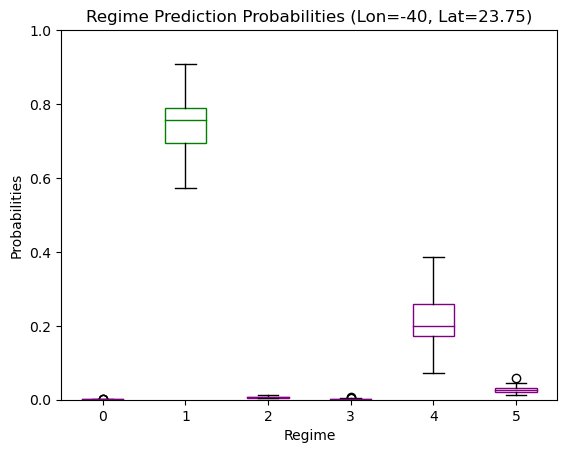

In [25]:
plot_predicted_probabilities(lon=-40, lat=23.75)

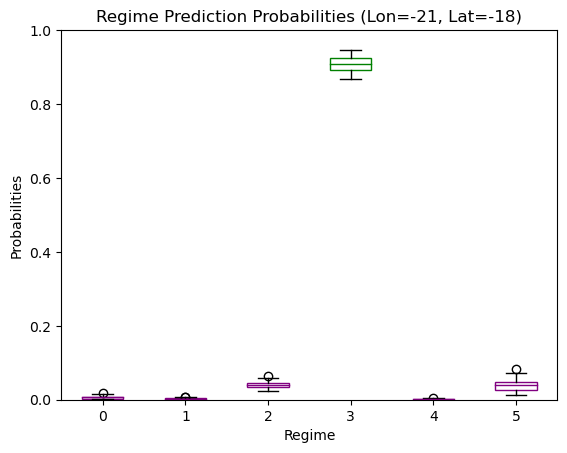

In [26]:
plot_predicted_probabilities(lon=-21, lat=-18)

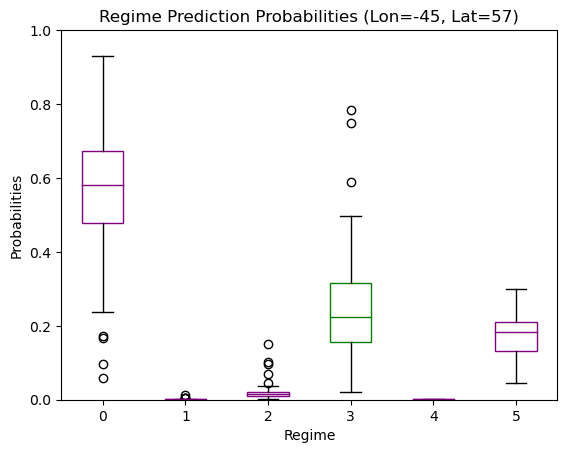

In [27]:
plot_predicted_probabilities(lon=-45, lat=57)

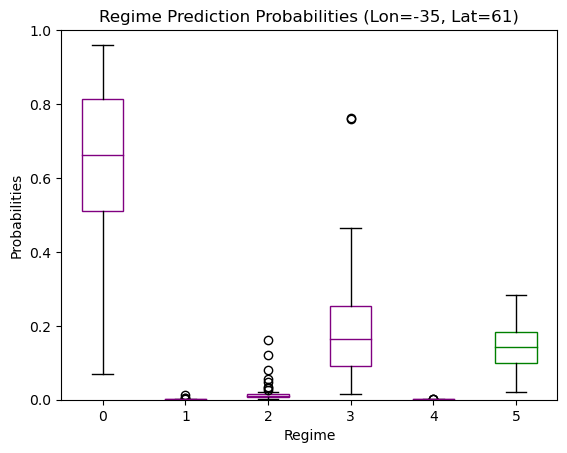

In [28]:
plot_predicted_probabilities(lon=-35, lat=61)

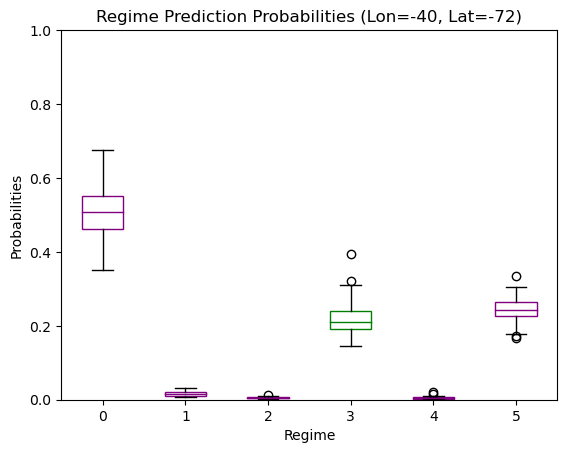

In [29]:
plot_predicted_probabilities(lon=-40, lat=-72)

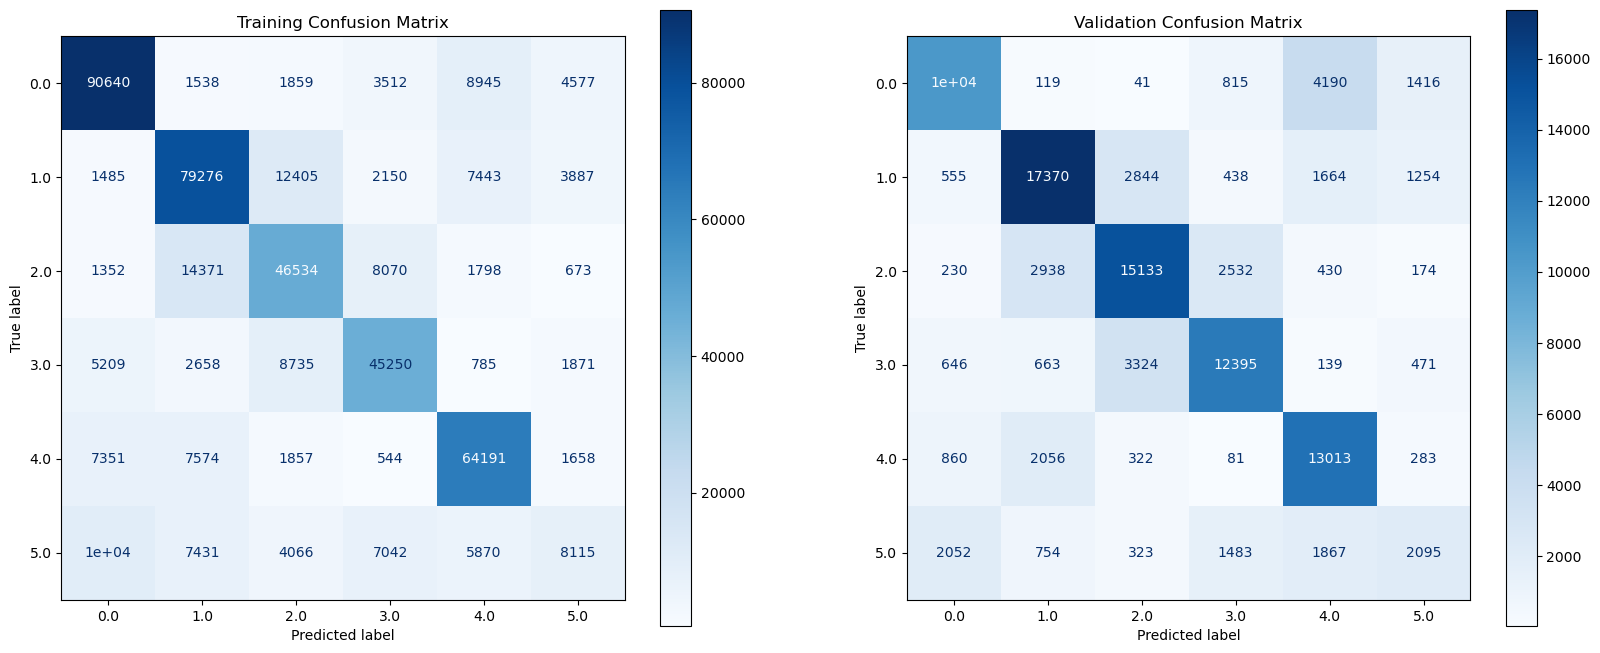

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))

ConfusionMatrixDisplay.from_predictions(train_labels, pred.data.flatten()[maskTraining.flatten()], ax=axes[0], cmap='Blues')
axes[0].set_title('Training Confusion Matrix')

ConfusionMatrixDisplay.from_predictions(val_labels, pred.data.flatten()[maskVal.flatten()], ax=axes[1], cmap='Blues')
axes[1].set_title('Validation Confusion Matrix')

plt.show()

In [31]:
from sklearn.metrics import classification_report
target_names = ['class ' + str(i) for i in range(num_clusters)]
print(classification_report(val_labels, pred.data.flatten()[maskVal.flatten()], target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.70      0.61      0.65     16948
     class 1       0.73      0.72      0.72     24125
     class 2       0.69      0.71      0.70     21437
     class 3       0.70      0.70      0.70     17638
     class 4       0.61      0.78      0.69     16615
     class 5       0.37      0.24      0.29      8574

    accuracy                           0.67    105337
   macro avg       0.63      0.63      0.63    105337
weighted avg       0.66      0.67      0.66    105337

